# 08.06 Hierarchical

There are more clustering techniques out there.
Notably techniques that can deal directly with non-linearity to some extent.
We will look at a group of clustering techniques that are called
Hierarchical or Agglomerative Clustering depending on who is naming it.

We import things we saw before and the Agglomerative Clustering from `sklearn`.
Also, we import `make_moons` which it a dataset constructor similar
to `make_blobs` we saw before.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.datasets import make_moons, load_digits
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import v_measure_score

![Moon](ul-moon.svg)

<div style="text-align:right;"><sup>ul-moon.svg</sup></div>

The `make_moons` procedure builds a dataset with a touch of nonlinearity.
Here we build two crescent moons with a tiny amount of noise.
The dataset construction procedure provides us with labels.

We will use the labels to visually verify what the clustering techniques
are doing on the dataset but will not provide the labels to the algorithms.
To view the ground truth we will be working with we first plot the
entire dataset with the labels originally generated.

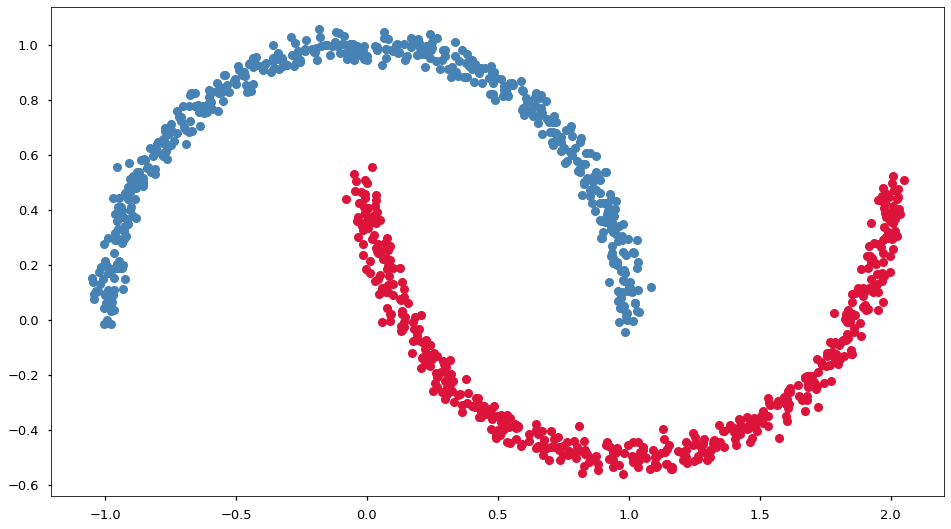

In [2]:
X, y = make_moons(1024, noise=.03)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X[y == 1, 0], X[y == 1, 1], 'o', c='crimson')
ax.plot(X[y == 0, 0], X[y == 0, 1], 'o', c='steelblue');

For a quick start we will attempt our good friend k-means.
We know that the number of clusters is $2$ hence we
can easily feed that into k-means.

We again use `fit_predict` and `v_measure` to evaluate how well
the clustering works.
On top of that we plot the classes according to the clusters
k-means reached.

0.1830425962550414

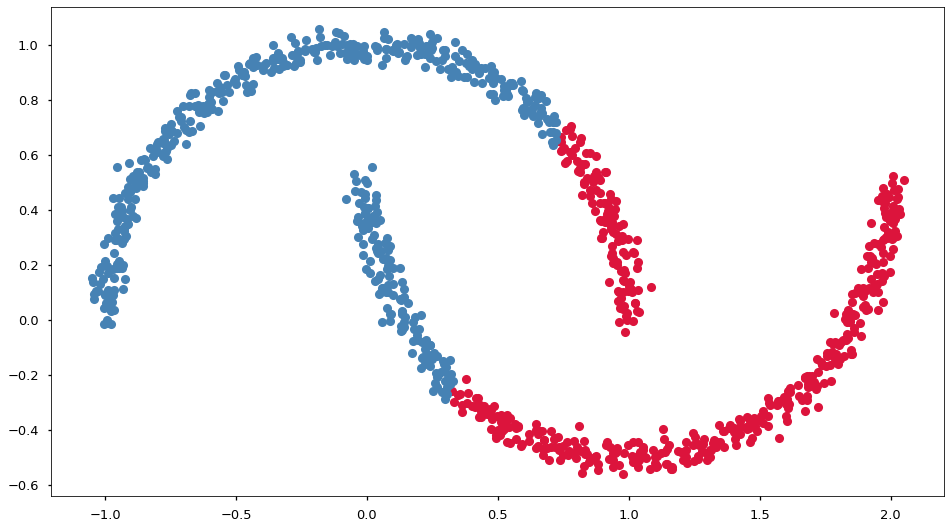

In [3]:
model = MiniBatchKMeans(n_clusters=2)
y_hat = model.fit_predict(X)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X[y_hat == 1, 0], X[y_hat == 1, 1], 'o', c='crimson')
ax.plot(X[y_hat == 0, 0], X[y_hat == 0, 1], 'o', c='steelblue')
v_measure_score(y, y_hat)

And k-means is *not* a good clustering technique for this dataset.
This is because k-means depends purely on distance from the cluster center,
the clusters k-means produces do not follow the structure of the dataset.

In order to follow the non-linear structure in the two moons we will
use a form of clustering that cares about the distances between
the points in the dataset rather the distance of every points
to an arbitrary point in space.

Agglomerative (Or Hierarchical) clustering works by assigning as many clusters
as there are data points in the dataset,
and every cluster contains a single sample.
Then an iterative algorithms attempts to join the clusters together
by following the nest steps:

1. *Measure the distance* between every pair of clusters
2. Join together the two *closest* clusters, making them into a single cluster
3. repeat steps 1 and 2 until the desired number of clusters is reached

Note that the clusters *have no centers* bu only samples,
hence joining two clusters together simply means placing the samples
in the same cluster.
Since there are no centers measuring the distance between
clusters becomes a tad complicated.
This distance measure is called **linkage** in hierarchical
clustering, and the choice of linkage produces very different clusters.
When evaluating the distance between two clusters,
each cluster is formed of one or more samples
and each sample has a position.
All samples in one cluster have a distance to all samples
in the second cluster, and linkage is a way to make these
distances into a single value.

- **single linkage** considers the shorter distance as
  the distance between clusters.

- **complete linkage** uses the maximum distance.

- **average linkage** takes the average of all distances.

- **ward linkage** is a little different,
  instead of using the distances between the clusters
  it attempts to minimize the variance of the cluster
  after the merge.
  In other words the cluster merge it will perform
  will be the one which increases the total variances
  within clusters the least.

The algorithm is called agglomerative because we keep joining
the clusters together.
And is called hierarchical because we can join all clusters
all the way until we remain with only a single cluster.
Then the path taken by the algorithm to reach the single cluster
can be considered to be a hierarchy of joins.
If the number of clusters to find is not too big agglomerative
clustering will perform all joins up to a single cluster and then
walk the path of the joins to find a place where the desired number
of clusters exist.
The path of the joins is cached,
hence it is possible to ask to cluster into several numbers of clusters
repeatedly at minimal cost.

The linkage is given by the appropriately named `linkage=` argument.
In order to compare the performance of the different linkage schemes,
we perform each and graph them.
We also add the v-measure as the title of each graph for comparison.

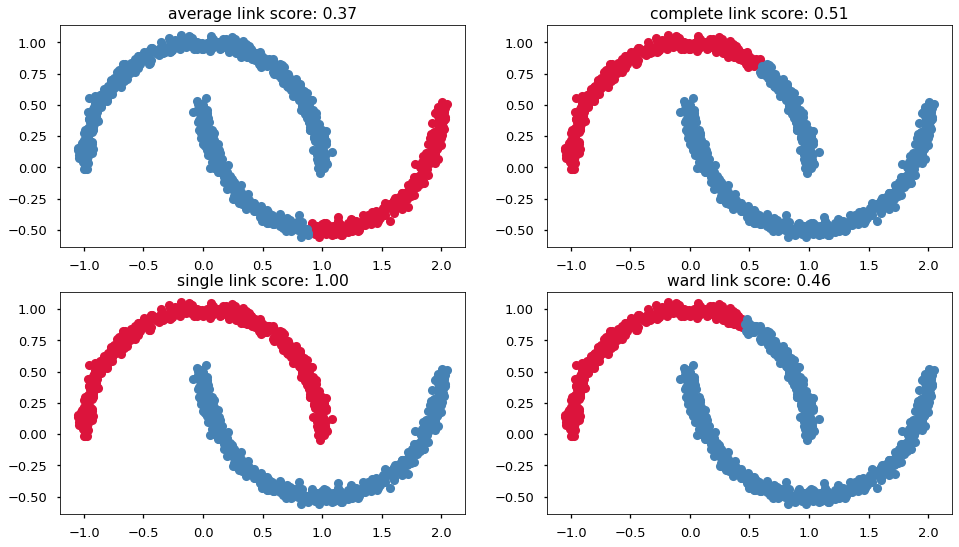

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

for axf, link in zip(ax.flat, ['average', 'complete', 'single', 'ward']):
    model = AgglomerativeClustering(n_clusters=2, linkage=link)
    y_hat = model.fit_predict(X)
    score = v_measure_score(y, y_hat)
    axf.plot(X[y_hat == 1, 0], X[y_hat == 1, 1], 'o', c='crimson')
    axf.plot(X[y_hat == 0, 0], X[y_hat == 0, 1], 'o', c='steelblue');
    axf.set_title('%s link score: %.02f' % (link, score))

When the classes have well defined and also well separated structure
single linkage appears to work very well.
Other linkages performed rather randomly,
some as badly as k-means whilst others somewhere in between.
In this dataset the exact score of the other three linkages
is heavily dependent on the random noise in the position of the points.
But we cannot take at face value that the single linkage work well for every dataset.

A dataset we already did see that we know that the separation between classes
is bad is the digits dataset.
The issue with that dataset is that it is hard to visualize what is happening
in it because the dataset itself is hard to visualize.
In order to see what is happening we will perform t-SNE on the digits dataset
and will plot the results of our clustering in the t-SNE projection.
But we will *not* give this projection to the agglomerative clustering algorithm,
we will give the algorithm the plain data in all $2914$ dimensions.

In [5]:
digits = load_digits()
digits.data.shape, digits.images.shape
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(digits.data)

The v-measure of plain k-means on the digits dataset was slightly above $0.7$.
We will again evaluate all four linkage methods on clustering the digits
in $2914$ dimensions.

We will plot the results in a similar fashion to the way we displayed
the t-SNE projections before.
In order to do that we need to scale our data to a unit square
so that the plotting engine has an easy time displaying the graph.

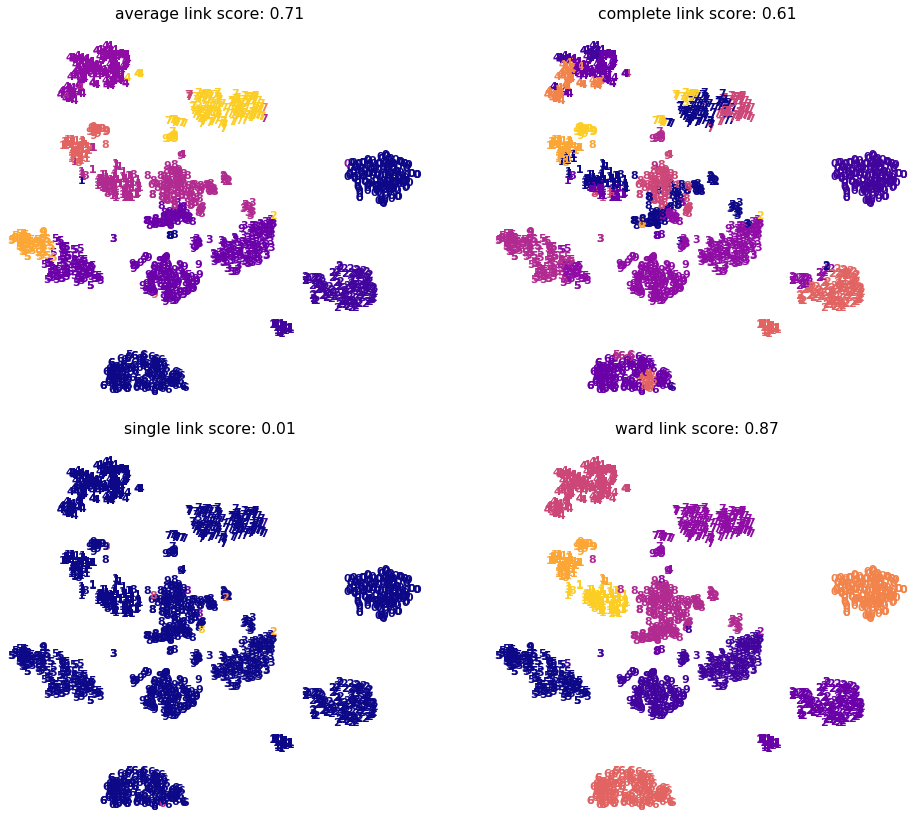

In [6]:
def plot_digits(X, y, ax):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    proj_norm = (X - x_min) / (x_max - x_min)

    ax.axis('off')
    for i in range(len(y)):
        ax.text(proj_norm[i, 0], proj_norm[i, 1], str(digits.target[i]),
                color=plt.cm.plasma(y[i] / 10),
                fontdict=dict(size=11, weight='bold'))


fig, ax = plt.subplots(2, 2, figsize=(16, 14))
for axf, link in zip(ax.flat, ['average', 'complete', 'single', 'ward']):
    model = AgglomerativeClustering(n_clusters=10, linkage=link)
    y_hat = model.fit_predict(digits.data)
    score = v_measure_score(digits.target, y_hat)
    plot_digits(proj, y_hat, axf)
    axf.set_title('%s link score: %.02f' % (link, score), pad=30)

An in the case of digits the single linkage performed exceptionally badly.
The classes in the digits dataset are very close to each other
therefore single linkage just made $9$ clusters with a single sample each
and a $10th$ cluster with all other samples.
The ward linkage on the other hand performs very well on this problem.

Do not be mislead by the graphs.
The actual data samples are all very close to each other in $2914$ dimensions.
The graphs use the t-SNE projection in order for us to be able to visually
inspect what the agglomerative clustering graph is doing.

The take home message is that algorithms that are capable of dealing
with non-linearities are often unstable - they work very well on some
problems whilst badly on others.
In these cases nothing substitutes our own understanding of the data,
which allows us to guesstimate which algorithm is performing well and why.

Agglomerative clustering is powerful but it is not the only form of clustering
that can account for non-linearities.
We did see that agglomerative clustering caches the path of joins.
Moreover, it considers all samples at every iteration,
which makes it impossible to scale the algorithm to big datasets.
The scaling issue in clustering is a common issue.
Pretty much all advanced clustering algorithms do not scale well.
If your dataset has millions of samples and hundreds of features,
your only option is k-means.

# References

[SciKit Learn - Digits Dataset Cluster Linkage][1]

[1]: https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html